Temperature: 0.1
Temperature: 0.2
Temperature: 0.30000000000000004
Temperature: 0.4
Temperature: 0.5
Temperature: 0.6
Temperature: 0.7000000000000001
Temperature: 0.8
Temperature: 0.9
Temperature: 1.0
Temperature: 1.1
Temperature: 1.2000000000000002
Temperature: 1.3000000000000003
Temperature: 1.4000000000000001
Temperature: 1.5000000000000002
Temperature: 1.6
Temperature: 1.7000000000000002
Temperature: 1.8000000000000003
Temperature: 1.9000000000000001
Temperature: 2.0
Temperature: 2.1
Temperature: 2.2
Temperature: 2.3000000000000003
Temperature: 2.4000000000000004
Temperature: 2.5000000000000004
Temperature: 2.6
Temperature: 2.7
Temperature: 2.8000000000000003
Temperature: 2.9000000000000004
Temperature: 3.0000000000000004
Temperature: 3.1
Temperature: 3.2
Temperature: 3.3000000000000003
Temperature: 3.4000000000000004


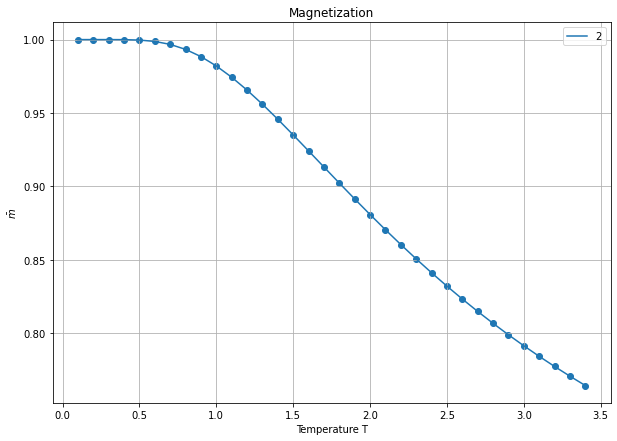

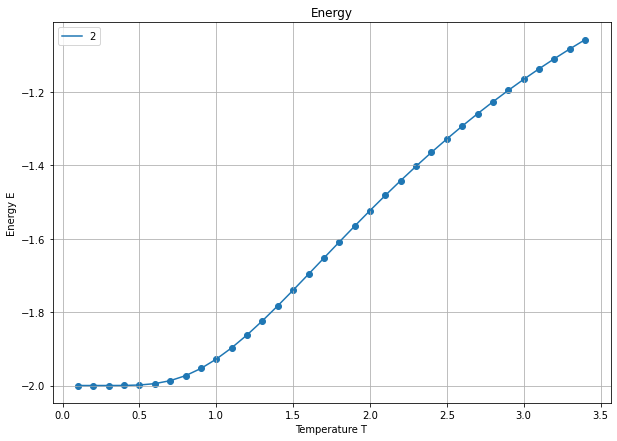

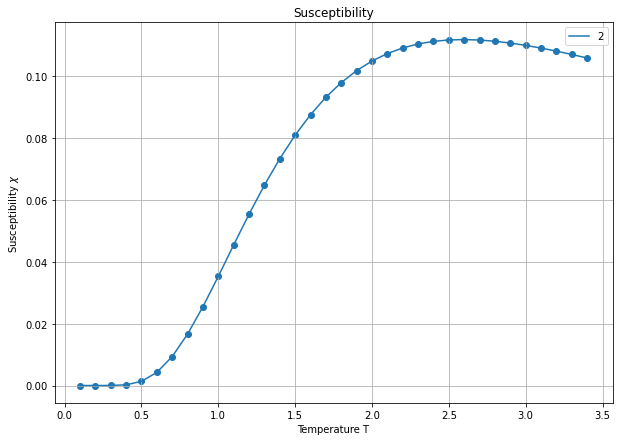

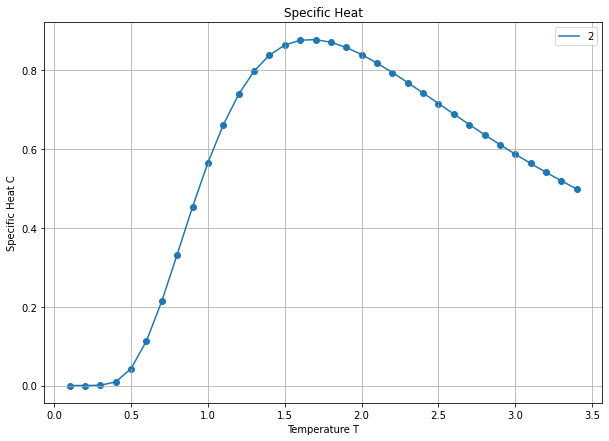

In [26]:
import itertools
import numpy as np
from scipy import ndimage
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


def generate_configurations(N: int):
    arr = [[1, -1] for _ in range(N)]
    return np.array(list(itertools.product(*arr)))


def calculate_mag_energy(configuration):
    kernel = np.array([0, 0, 1])  # only the next element
    energy = (-configuration * ndimage.convolve(configuration, kernel, mode="wrap")).sum()
    magnetization = np.mean(configuration)
    return energy, magnetization


def count_spin_values(N: int, filepath: str, write: bool = True):
    arr = list()
    for i, conf in enumerate(generate_configurations(N)):
        e, m = calculate_mag_energy(conf)
        arr.append((e, m))

    counter = Counter(arr)  # key: (energy, magnetization)
    if write:
        with open(filepath, 'wb') as f:
            pickle.dump(counter, f)
    return counter


def get_spin_counter(filepath: str):
    with open(filepath, 'rb') as f:
        return pickle.load(f)


def calculate_pmf(T: float, value_pair: tuple, counter: Counter):
    return counter[value_pair] * np.exp(-1/T * value_pair[0])


def calculate_z(T: float, counter: Counter):
    Z = 0
    for k, v in counter.items():
        Z += calculate_pmf(T, k, counter)

    return Z


def calculate_mag_energy_f(filepath: str, T: float):
    counter = get_spin_counter(filepath)
    avg_magnetization, avg_magnetization_squared = 0, 0
    avg_energy, avg_energy_squared = 0, 0
    Z = calculate_z(T, counter)
    for k, v in counter.items():
        avg_magnetization += np.abs(k[1]) * calculate_pmf(T, k, counter) / Z
        avg_magnetization_squared += np.power(k[1], 2) * calculate_pmf(T, k, counter) / Z
        avg_energy += k[0] * calculate_pmf(T, k, counter) / Z
        avg_energy_squared += np.power(k[0], 2) * calculate_pmf(T, k, counter) / Z

    return avg_magnetization, avg_magnetization_squared, avg_energy, avg_energy_squared


def calculate_susceptibility_f(filepath: str, T: float, N: int, normalized=False):
    avg_mag, avg_mag_sq, _, _ = calculate_mag_energy_f(filepath, T)
    if normalized:
        return (avg_mag_sq - np.power(avg_mag, 2)) / T * N
    return (avg_mag_sq - np.power(avg_mag, 2)) / T * N


def calculate_specific_heat(filepath: str, T: float, N: int):
    _, _, avg_energy, avg_energy_sq = calculate_mag_energy_f(filepath, T)
    return (avg_energy_sq - np.power(avg_energy, 2)) / T ** 2 * N


def plot_MEX(magnetization_arr: np.array, energy_arr: np.array, susceptibility_arr: np.array, specific_heat: np.array,
             T_arr: np.array, labels: list):
    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        sns.lineplot(x=T_arr, y=magnetization_arr[i], label=label)
        plt.scatter(T_arr, magnetization_arr[i])
        plt.title(f"Magnetization")
        plt.ylabel(r'$\bar{m}$')
        plt.xlabel("Temperature T")

    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        sns.lineplot(x=T_arr, y=energy_arr[i], label=label)
        plt.scatter(T_arr, energy_arr[i])
        plt.title(f"Energy")
        plt.ylabel(r'Energy E')
        plt.xlabel("Temperature T")

    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        sns.lineplot(x=T_arr, y=susceptibility_arr[i], label=label)
        plt.scatter(T_arr, susceptibility_arr[i])
        plt.title(f"Susceptibility")
        plt.ylabel(r'Susceptibility $\chi$')
        plt.xlabel("Temperature T")

    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 7))
    for i, label in enumerate(labels):
        sns.lineplot(x=T_arr, y=specific_heat[i], label=label)
        plt.scatter(T_arr, specific_heat[i])
        plt.title(f"Specific Heat")
        plt.ylabel(r'Specific Heat C')
        plt.xlabel("Temperature T")

    plt.grid()
    plt.show()


if __name__ == "__main__":
    N_arr = [2]
    T_min = 0.1
    T_max = 3.5
    T_arr = np.arange(T_min, T_max, 0.1)
    #
    filepath = f"./em_count_N{N_arr[0]}.pkl"
    count_spin_values(N_arr[0], filepath, write=True)
    #
    M = np.zeros(shape=(len(N_arr), T_arr.shape[0]))
    E = np.zeros(shape=(len(N_arr), T_arr.shape[0]))
    X = np.zeros(shape=(len(N_arr), T_arr.shape[0]))
    C = np.zeros(shape=(len(N_arr), T_arr.shape[0]))

    for i, N in enumerate(N_arr):
        for j, T in enumerate(T_arr):
            print(f"Temperature: {T}")
            filepath = f"./em_count_N{N}.pkl"
            M[i, j], _, E[i, j], _ = calculate_mag_energy_f(filepath, T)
            # E[i, j] /= N
            X[i, j] = calculate_susceptibility_f(filepath, T, N, normalized=True)
            C[i, j] = calculate_specific_heat(filepath, T, N)

    plot_MEX(M, E, X, C, T_arr, N_arr)
    #
    # conf = generate_configurations(2)
    # for c in conf:
    #     print(calculate_mag_energy(c))

    #
    # for con in generate_configurations(4):
    #     print(con)
    #     print(calculate_mag_energy(con))


